In [1]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *
import      configparser

inputs = configparser.ConfigParser()


#path dove stanno i dati del fit

spectra_filename    =   'ARS_14_02'

analysis_dir = 'analysis_new_master_better'


spectra_path = '../BRILLOUIN/TDP43/'+spectra_filename+'/'
now_path = spectra_path+analysis_dir+'/'


with open(now_path+'config.ini', 'r') as f:
    inputs.read_file(f)
### recupero info su dimensionalità
n_rows    =     inputs.getint('I/O', 'n_rows')
n_cols    =     inputs.getint('I/O', 'n_cols')
###

matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 85x62, per un totale di 5270 spettri


In [2]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

"""
x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)


for (ii,jj) in boni:
    matrix[ii][jj].Recover_VIPA(x_VIPA, y_VIPA)
"""

count = 0
for (ii,jj) in serpentine_range(n_rows, n_cols, 'right'):
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [3]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))


for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


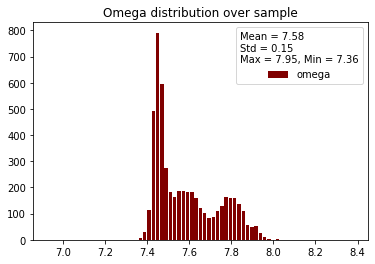

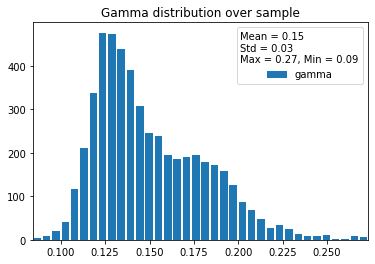

In [4]:
#HISTOGRAMs - MARKOV
markov_Omegas = np.array([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
markov_Gammas =  np.array([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])

#escludo outlier
markov_Omegas = markov_Omegas[np.where(markov_Omegas < 8.5)[0]]
markov_Omegas = markov_Omegas[np.where(markov_Omegas > 7.)[0]]

markov_Gammas = markov_Gammas[np.where(markov_Gammas < 0.35)[0]]
markov_Gammas = markov_Gammas[np.where(markov_Gammas > 0.05)[0]]

plt.figure()
plt.title('Omega distribution over sample')
bins = plt.hist(markov_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
#escludo outlayer, chi ha popolazione in questo binning minore di N VA A CASA
omega_N = 4
markov_omega_min = np.min(bins[1][np.where(bins[0] > omega_N)])
markov_omega_max = np.max(bins[1][np.where(bins[0] > omega_N)])

plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}\nMax = {:3.2f}, Min = {:3.2f}'.format(np.mean(markov_Omegas), np.std(markov_Omegas), markov_omega_max, markov_omega_min))
plt.xlim(markov_omega_min -0.5, markov_omega_max + 0.5)
plt.savefig(now_path+'Omega_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
plt.title('Gamma distribution over sample')
bins = plt.hist(markov_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
gamma_N = 5
markov_gamma_min = np.min(bins[1][np.where(bins[0] > gamma_N)])
markov_gamma_max =  np.max(bins[1][np.where(bins[0] > gamma_N)])

plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}\nMax = {:3.2f}, Min = {:3.2f}'.format(np.mean(markov_Gammas), np.std(markov_Gammas), markov_gamma_max, markov_gamma_min))
plt.xlim(markov_gamma_min -0.005, markov_gamma_max + 0.005)
plt.savefig(now_path+'Gamma_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')

plt.show()
plt.close()


In [5]:
bins

(array([  3.,   8.,  21.,  41., 116., 212., 338., 476., 473., 438., 391.,
        308., 245., 238., 195., 186., 190., 196., 179., 173., 159., 126.,
         88.,  69.,  47.,  27.,  33.,  24.,  13.,   9.,   8.,  10.,   2.,
          2.,   9.,   6.,   1.,   5.,   2.,   2.,   5.,   4.,   2.,   1.,
          3.,   2.,   3.,   4.,   2.,   1.]),
 array([0.0841092 , 0.08936545, 0.09462169, 0.09987793, 0.10513417,
        0.11039041, 0.11564666, 0.1209029 , 0.12615914, 0.13141538,
        0.13667163, 0.14192787, 0.14718411, 0.15244035, 0.1576966 ,
        0.16295284, 0.16820908, 0.17346532, 0.17872156, 0.18397781,
        0.18923405, 0.19449029, 0.19974653, 0.20500278, 0.21025902,
        0.21551526, 0.2207715 , 0.22602774, 0.23128399, 0.23654023,
        0.24179647, 0.24705271, 0.25230896, 0.2575652 , 0.26282144,
        0.26807768, 0.27333393, 0.27859017, 0.28384641, 0.28910265,
        0.29435889, 0.29961514, 0.30487138, 0.31012762, 0.31538386,
        0.32064011, 0.32589635, 0.33115259, 0.

In [6]:
#Parametri di Interesse per analisi
markov_too_bad = ()
markov_too_good  = ()
markov_omega_too_high =  ()
markov_gamma_too_bad = ()

cost_max = 1000
cost_min = 50


markov_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'markov')
markov_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'markov')
markov_omega_too_high = Whose_Param_Too_High('Omega', markov_omega_max, 'markov', matrix, boni)
markov_gamma_too_high = Whose_Param_Too_High('Gamma', markov_gamma_max, 'markov', matrix, boni)
markov_omega_too_low = Whose_Param_Too_Low('Omega', markov_omega_min, 'markov', matrix, boni)
markov_gamma_too_low = Whose_Param_Too_Low('Gamma', markov_gamma_min, 'markov', matrix, boni)

#aggiunte 
markov_too_offset = ()
percentage_gamma = 15
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        markov_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        markov_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        markov_almost_height += ((ii,jj),)


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(markov_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(markov_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(markov_omega_too_high), markov_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(markov_gamma_too_high), markov_gamma_max))


print('{} elementi con Omega < Omega min {:3.2f}'.format(len(markov_omega_too_low), markov_omega_min))
print('{} elementi con Gamma < Gamma min {:3.2f}\n'.format(len(markov_gamma_too_low), markov_gamma_min))

print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(markov_too_offset), max_offset))





I found 1 bad elements out of 5106

I found 2834 good elements out of 5106





Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/ARS_14_02/analysis_new_master_better/ :

1 elementi con chi quadro > 1000 
2834 elementi con chi quadro < 50 

17 elementi con Omega > Omega max 7.95
53 elementi con Gamma > Gamma max 0.27

2 elementi con Omega < Omega min 7.36
3 elementi con Gamma < Gamma min 0.09

243 elementi con Gamma con errore percentuale > 15 

464 elementi con offset > 30 



Completata Parameter_Map per Omega
Ho trovato 164 elementi saturati
Completata Parameter_Map per Omega
Ho trovato 164 elementi saturati
Completata Parameter_Map per Gamma
Ho trovato 164 elementi saturati
Completata Parameter_Map per Gamma
Ho trovato 164 elementi saturati


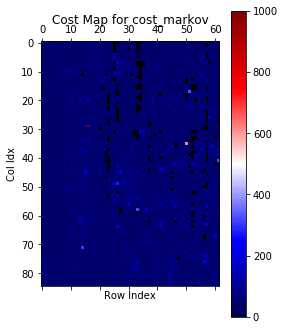

In [7]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

In [8]:
#STAMPA MAPPE
name = '+ARS 72h'
pix_scale = 240#nm
omega_max = 7.9
omega_min = 7.3
gamma_max = 0.235
gamma_min = 0.1

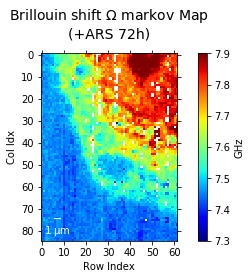

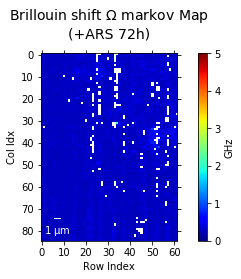

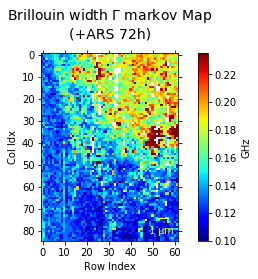

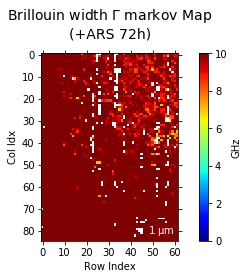

In [9]:

Print_Parameter_Map(omega_markov_map, omega_min, omega_max, 'Omega', 'markov', name = name, pix_scale = pix_scale, filename = 'omega_markov_map', path=now_path, bar_loc = 'lower left')
Print_Parameter_Map(Delta_omega_markov_map, 0, 5, 'Omega', 'markov', name = name, pix_scale = pix_scale, filename = 'Delta_omega_markov_map', path=now_path, bar_loc = 'lower left')
Print_Parameter_Map(gamma_markov_map, gamma_min, gamma_max, 'Gamma', 'markov', name = name, pix_scale = pix_scale, filename = 'gamma_markov_map', path=now_path, bar_color = 'yellow')
Print_Parameter_Map(Delta_gamma_markov_map, 0, 10, 'Gamma', 'markov', name = name, pix_scale = pix_scale, filename = 'DElta_gamma_markov_map', path=now_path)

In [10]:
#INTERPOLATION MAPPE
omega_markov_map_inter = Interpolate_Parameter_Map(omega_markov_map, 'Omega', 'markov', matrix, n_rows, n_cols, markov_omega_min, markov_omega_max)
gamma_markov_map_inter = Interpolate_Parameter_Map(gamma_markov_map, 'Gamma', 'markov', matrix, n_rows, n_cols, markov_gamma_min, markov_gamma_max)


Completata Interpolazione per elementi di markov Omega map 

Completata Interpolazione per elementi di markov Gamma map 



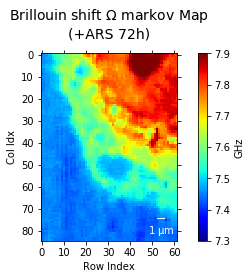

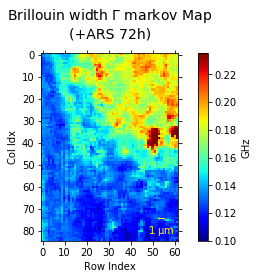

In [11]:
#STAMPA MAPPE INTERPOLATE
Print_Parameter_Map(omega_markov_map_inter, omega_min, omega_max, 'Omega', 'markov', name = name, pix_scale = pix_scale, filename = 'omega_markov_map_inter', path=now_path)
Print_Parameter_Map(gamma_markov_map_inter, gamma_min, gamma_max, 'Gamma', 'markov', name = name, pix_scale = pix_scale, filename = 'Gamma_markov_map_inter', path=now_path, bar_color = 'yellow')


In [12]:
#identificatore:
nucleo = []
citoplasma = []
granuli = []

for ii,jj in boni:
    if matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] > 7.8: nucleo.append((ii,jj))
    if matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] > .23 : granuli.append((ii,jj))
    if (matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] > 7.5) & (matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] < 7.75): citoplasma.append((ii,jj))


(69, 9)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.008137  7.446945  0.132720        0.106832  2.534390e-10   
StdErrs   0.010966  0.026959  0.015635        0.000889  4.706647e-03   
Initials  0.008142  7.447651  0.132869        0.106822  1.630186e-09   

          delta_amplitude             A         mu      sigma     shift  \
Values       3.495274e-01  1.293726e-01  -6.449205  14.957145  0.223193   
StdErrs      6.491112e+06  3.037931e+06  31.893555  26.829575  0.020882   
Initials     3.495274e-01  1.293726e-01  -6.449185  14.957137  0.222823   

             offset  
Values    10.873748  
StdErrs    0.961468  
Initials  10.870058  


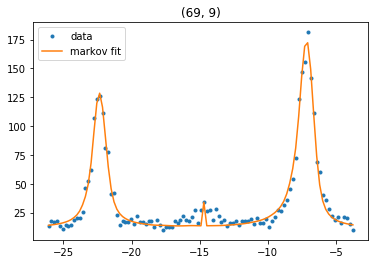

(69, 10)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.008581  7.376042  0.158413        0.106836  1.052676e-10   
StdErrs   0.013483  0.022709  0.017081        0.007404           NaN   
Initials  0.008256  7.440247  0.139868        0.106836  1.000000e-10   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.015587  2.237909e-04  -6.276971  14.870095  0.212295   
StdErrs               NaN  1.945941e+06  37.663864  30.998869  0.022930   
Initials         0.014807  2.562326e+02  -6.340375  14.884886  0.170138   

             offset  
Values    21.140867  
StdErrs    1.068392  
Initials  22.703540  


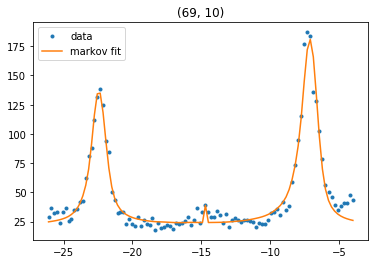

(69, 11)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.007648  7.452023  0.120531        0.106767  9.533459e-07   
StdErrs   0.011814  0.020568  0.014688        0.000415  6.092777e-02   
Initials  0.007794  7.452972  0.126084        0.106822  1.814818e-07   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.013437  1.213069e+00  -6.636490  14.947196  0.180910   
StdErrs        858.593171  2.538444e+06  35.460074  30.634738  0.019810   
Initials         0.003756  1.374802e+01  -6.570784  14.932264  0.182925   

             offset  
Values    13.084160  
StdErrs    1.027002  
Initials  12.208893  


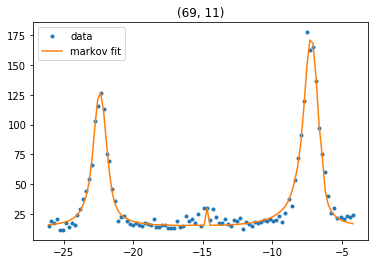

(70, 9)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.007686  7.430663  0.117279        0.106774  2.931105e-09   
StdErrs   0.011091  0.020728  0.014500        0.000027  6.227450e-03   
Initials  0.008137  7.446945  0.132720        0.106832  2.534390e-10   

          delta_amplitude             A         mu      sigma     shift  \
Values       4.415594e+00  5.322781e+00  -6.384713  14.942188  0.189521   
StdErrs      9.381407e+06  1.421821e+07  34.230095  28.667535  0.019716   
Initials     3.495274e-01  1.293726e-01  -6.449205  14.957145  0.223193   

             offset  
Values    12.816990  
StdErrs    0.981743  
Initials  10.873748  


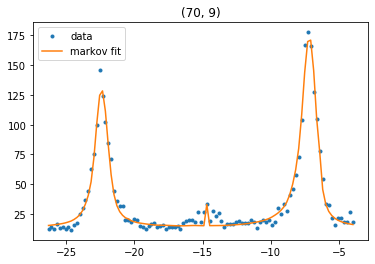

(70, 11)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.007967  7.439241  0.135414        0.106781  4.681053e-07   
StdErrs   0.011087  0.020524  0.014656        0.000898  1.624116e-01   
Initials  0.007648  7.452023  0.120531        0.106767  9.533459e-07   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.020124  1.213075e+00  -6.570126  14.932250  0.171264   
StdErrs       6981.582829  2.929926e+06  32.174180  27.592466  0.020726   
Initials         0.013437  1.213069e+00  -6.636490  14.947196  0.180910   

             offset  
Values    11.774153  
StdErrs    0.947488  
Initials  13.084160  


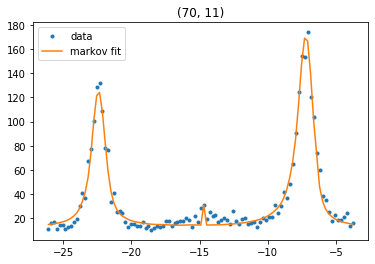

(71, 9)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.008203  7.457046  0.134743        0.106818  6.205261e-10   
StdErrs   0.010833  0.022419  0.017138        0.000174  1.819842e-03   
Initials  0.007686  7.430663  0.117279        0.106774  2.931105e-09   

          delta_amplitude             A         mu      sigma     shift  \
Values       1.966472e+00  3.809205e+02  -6.331129  14.929262  0.226667   
StdErrs      5.767143e+06  1.049917e+09  31.529333  26.128618  0.020286   
Initials     4.415594e+00  5.322781e+00  -6.384713  14.942188  0.189521   

             offset  
Values    10.931428  
StdErrs    0.928979  
Initials  12.816990  


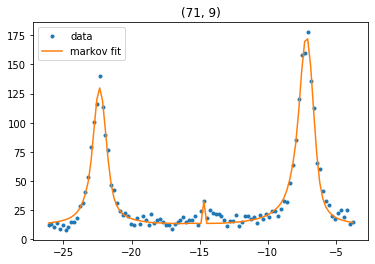

(71, 10)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.008063  7.411247  0.154003        0.106836  1.019116e-10   
StdErrs   0.013440  0.022998  0.017452        0.009102  2.763599e-03   
Initials  0.008581  7.376042  0.158413        0.106836  8.397204e-11   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.015884  1.264208e+00  -6.339741  14.884965  0.217530   
StdErrs     430740.101686  2.878747e+06  39.562691  32.818196  0.022732   
Initials         0.015587  2.237909e-04  -6.276971  14.870095  0.212295   

             offset  
Values    21.502118  
StdErrs    1.123754  
Initials  21.140867  


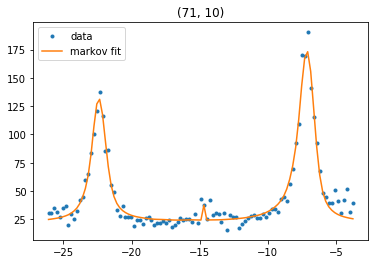

(71, 11)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.007851  7.440310  0.113035        0.106814  1.834791e-07   
StdErrs   0.010884  0.020387  0.013383        0.021202  2.621128e+00   
Initials  0.007967  7.439241  0.135414        0.106781  4.681053e-07   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.007886  2.262437e+01  -6.504425  14.917318  0.163651   
StdErrs     112654.337119  5.874004e+07  32.161203  27.384309  0.019296   
Initials         0.020124  1.213075e+00  -6.570126  14.932250  0.171264   

             offset  
Values    12.180003  
StdErrs    0.991482  
Initials  11.774153  


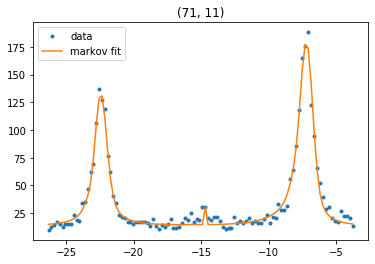

In [13]:
Plot_Elements_Spectrum(matrix, Get_Neighbours2D(70, 10, n_rows, n_cols), fit = 'markov')

In [14]:
#salvo
path = '../BRILLOUIN/TDP43/'
np.save(path +'markov_Omegas'+name, markov_Omegas)
np.save(path +'markov_Gammas'+name, markov_Gammas)
np.save(path +'markov_omega_map'+name, omega_markov_map_inter)
np.save(path +'markov_gamma_map'+name, gamma_markov_map_inter)

(70, 58)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.008035  7.503825  0.114821        0.034822     0.062431   
StdErrs   0.035155  0.029736  0.017328        0.012436     0.014300   
Initials  0.008173  7.519689  0.120370        0.114655     0.069406   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.083667  7.915852e+00  -6.391204  14.794431 -0.010068   
StdErrs          0.022657  1.107296e+07  97.011115  83.367131  0.024999   
Initials         0.113493  3.479841e-03  -6.327925  14.779651 -0.011677   

             offset  
Values    32.238270  
StdErrs    3.897741  
Initials  30.756468  


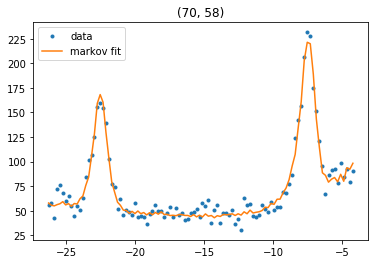

(70, 55)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.008074  7.512693  0.122331        0.033168     0.001832   
StdErrs   0.011820  0.020842  0.013694        0.001328     0.001308   
Initials  0.008333  7.534745  0.129664        0.026396     0.013113   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.002566  3.548376e+02  -7.964305  15.281729  0.060715   
StdErrs          0.001498  8.178592e+08  29.058330  30.908038  0.019275   
Initials         0.006559  1.020463e+01  -7.929422  15.266463  0.285129   

             offset  
Values     8.761834  
StdErrs    0.929231  
Initials  14.998607  


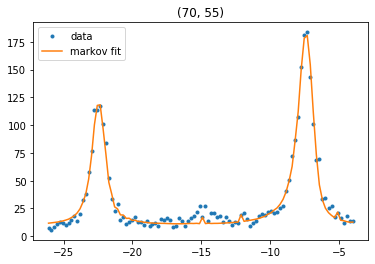

(70, 54)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.008190  7.520469  0.145773        0.032159  5.798171e-08   
StdErrs   0.011750  0.020351  0.014683        0.038251  2.949992e+00   
Initials  0.008074  7.512693  0.122331        0.033168  1.832152e-03   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.001408  3.405371e+00  -7.967077  15.296731  0.064511   
StdErrs      71631.289610  6.323799e+06  28.587901  30.361841  0.020526   
Initials         0.002566  3.548376e+02  -7.964305  15.281729  0.060715   

            offset  
Values    8.990468  
StdErrs   0.872869  
Initials  8.761834  


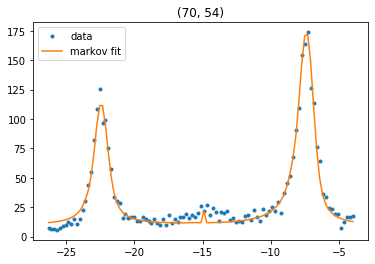

(70, 53)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.008242  7.500319  0.138402        0.032134  1.466376e-04   
StdErrs   0.011856  0.019024  0.013852        0.003080  1.170572e-03   
Initials  0.008190  7.520469  0.145773        0.032159  5.798171e-08   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.000269  2.852360e-06  -7.987618  15.312025  0.109000   
StdErrs          0.004255  1.830194e+06  28.860243  30.552288  0.019382   
Initials         0.001408  3.405371e+00  -7.967077  15.296731  0.064511   

            offset  
Values    8.610870  
StdErrs   0.894391  
Initials  8.990468  


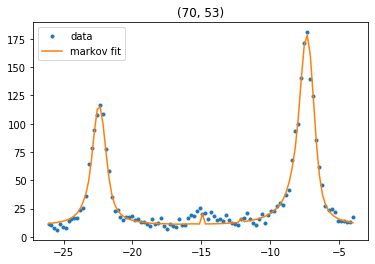

(71, 58)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.007853  7.507689  0.130774       -0.169398     0.036085   
StdErrs   0.017320  0.021243  0.016160        0.013659     0.014038   
Initials  0.007901  7.488277  0.120837       -0.115807     0.043455   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.012394  2.330643e-12  -7.542681  15.220694  0.019809   
StdErrs          0.003492  2.092292e+06  45.482648  45.896336  0.020846   
Initials         0.015430  1.295522e+00  -7.618870  15.235930  0.053048   

             offset  
Values    13.480526  
StdErrs    1.083671  
Initials  12.322022  


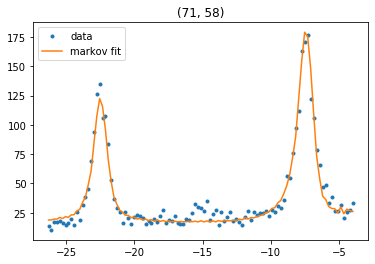

(71, 59)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.007702  7.505919  0.109669       -0.191146     0.052452   
StdErrs   0.019989  0.023544  0.015094        0.021017     0.021667   
Initials  0.007853  7.507689  0.130774       -0.169398     0.036085   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.019569  1.012912e+03  -7.618108  15.235915  0.239957   
StdErrs          0.004689  2.074243e+09  54.578326  54.190696  0.019727   
Initials         0.012394  2.330643e-12  -7.542681  15.220694  0.019809   

             offset  
Values    17.059527  
StdErrs    1.191996  
Initials  13.480526  


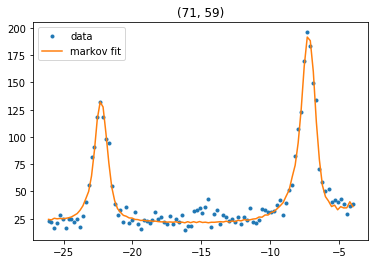

(71, 60)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.007943  7.514761  0.113004        0.191434     0.064250   
StdErrs   0.018303  0.023652  0.015867        0.019900     0.018976   
Initials  0.007702  7.505919  0.109669       -0.191146     0.052452   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.046921  6.915559e+01  -7.694289  15.251151  0.200253   
StdErrs          0.006846  1.252541e+08  47.711903  48.168199  0.020574   
Initials         0.019569  1.012912e+03  -7.618108  15.235915  0.239957   

             offset  
Values    21.009149  
StdErrs    1.639526  
Initials  17.059527  


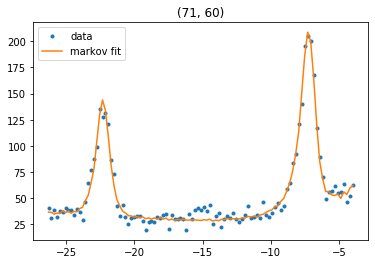

(71, 61)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.008031  7.540135  0.119716        0.097310     0.074196   
StdErrs   0.025972  0.025881  0.015834        0.027475     0.033117   
Initials  0.007943  7.514761  0.113004        0.191434     0.064250   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.046910  1.376100e-01  -7.771232  15.266402 -0.012897   
StdErrs          0.010840  2.195655e+06  64.197437  67.593309  0.022039   
Initials         0.046921  6.915559e+01  -7.694289  15.251151  0.200253   

             offset  
Values    19.245012  
StdErrs    1.923361  
Initials  21.009149  


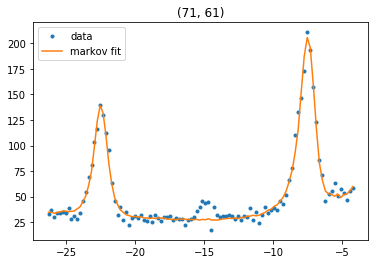

(72, 61)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.008012  7.527782  0.117640        0.108662     0.068102   
StdErrs   0.030119  0.027248  0.016375        0.018811     0.020234   
Initials  0.008031  7.540135  0.119716        0.097310     0.074196   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.063526  8.906404e-01  -7.815674  15.281668  0.003835   
StdErrs          0.014744  1.778650e+06  74.466546  78.814522  0.022747   
Initials         0.046910  1.376100e-01  -7.771232  15.266402 -0.012897   

             offset  
Values    24.372508  
StdErrs    2.903776  
Initials  19.245012  


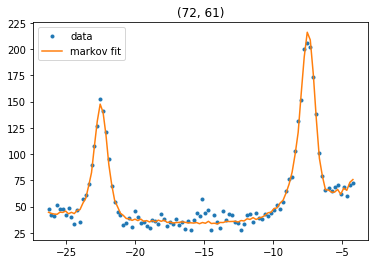

(75, 27)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.007613  7.519889  0.094972        0.714585     0.619503   
StdErrs   0.008646  0.024660  0.019375        0.194000     0.833940   
Initials  0.007759  7.485613  0.121154        0.760290     0.508974   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.099568  2.215015e+02  -5.794278  14.716498  0.077632   
StdErrs          0.059718  2.823128e+08  25.559355  20.698080  0.024405   
Initials         0.105714  1.316774e+02  -5.852806  14.731229  0.072385   

             offset  
Values    34.937275  
StdErrs   17.629245  
Initials  33.204503  


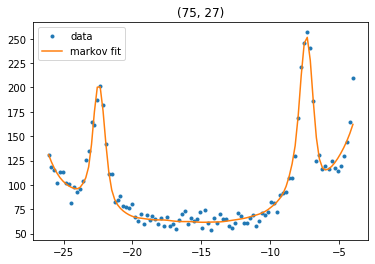

In [15]:
Plot_Elements_Spectrum(matrix, citoplasma[-10:], fit = 'markov')

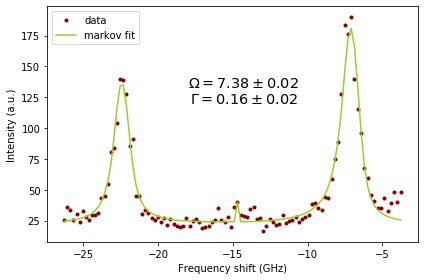

In [16]:
i = 70
j = 10
Data = matrix[i][j]
# MARKOV FIT EXAMPLE
f, ax = plt.subplots()
ax.plot(Data.x_freq, Data.y, '.', color = 'maroon', label = 'data')
ax.plot(Data.x_freq, Data.y_markov_fit, color = 'yellowgreen', label = 'markov fit')
ax.set_xlabel('Frequency shift (GHz)')
ax.set_ylabel('Intensity (a.u.)')
ax.text(-18., 120, '$\Omega = {:3.2f} \pm {:3.2f}$\n$\Gamma = {:3.2f} \pm {:3.2f}$'.format(Data.Markov_Fit_Params.T['Values']['Omega'], Data.Markov_Fit_Params.T['StdErrs']['Omega'], Data.Markov_Fit_Params.T['Values']['Gamma'], Data.Markov_Fit_Params.T['StdErrs']['Gamma']), ma = 'center', size = 'x-large', in_layout = True, fontstyle = 'italic', fontfamily = 'monospace')
ax.legend()
plt.tight_layout()
f.savefig(now_path+'markov_fit_example_acqua.pdf', format = 'pdf')

Text(0, 0.5, 'Intensity (a.u)')

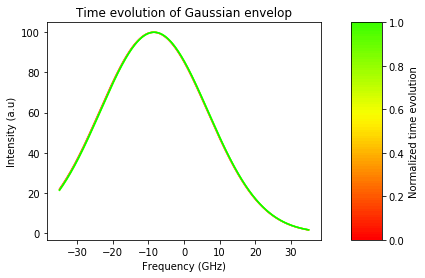

In [17]:
from colorsys import hsv_to_rgb
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib as mpl

def get_color(red_to_green):
    assert 0 <= red_to_green <= 1
    # in HSV, red is 0 deg and green is 120 deg (out of 360);
    # divide red_to_green with 3 to map [0, 1] to [0, 1./3.]
    hue = red_to_green / 3.0
    r, g, b = hsv_to_rgb(hue, 1, 1)
    return r,g,b

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.00
maxColor = 0.3
hsv_t = truncate_colormap(plt.get_cmap("hsv"), minColor, maxColor)
x = np.linspace(-35,35, 1000)
"""
f, ax = plt.subplots()
t_range = boni[:100]
for (ii,jj), kk in zip(t_range, range(len(t_range))):
    rgb =  get_color(kk/(len(t_range)-1))
    ax.plot(x, gaussian(x, 100, *matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']].values[0]), c = rgb)

ax.set_title('Time evolution of Gaussian envelop')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Intensity (a.u)')


cb = mpl.colorbar.ColorbarBase(cmap=hsv_t,
                               orientation='vertical')
"""
gs = gridspec.GridSpec(1,2,  width_ratios=[9, 1])
ax = [plt.subplot(g) for g in gs]
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].tick_params('y', left = False, right = True, labelright = False, labelleft = True)
cb = mpl.colorbar.ColorbarBase(ax[1], cmap=hsv_t,
                               orientation='vertical')
cb.set_label('Normalized time evolution')
t_range = boni[:5]
for (ii,jj), kk in zip(t_range, range(len(t_range))):
    rgb =  get_color(kk/(len(t_range)-1))
    ax[0].plot(x, gaussian(x, 100, *matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']].values[0]), c = rgb)

ax[0].set_title('Time evolution of Gaussian envelop')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Intensity (a.u)')

#plt.savefig('../Scrittek/figures/gaussian_flowing.pdf', format = 'pdf')



In [18]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


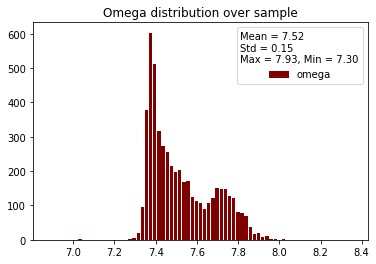

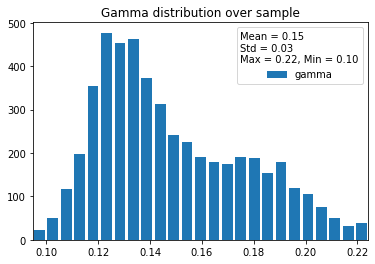

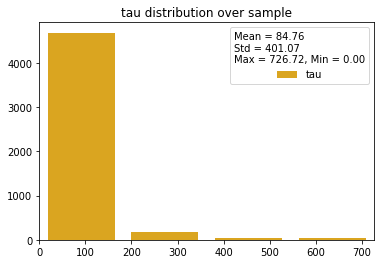

In [19]:
#HISTOGRAMs
tot_Omegas = np.array([matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
tot_Gammas =  np.array([matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])
tot_Taus       = np.array([matrix[ii][jj].Tot_Fit_Params['tau'].values[0] for (ii,jj) in boni])



#escludo outlier
tot_Omegas = tot_Omegas[np.where(tot_Omegas < 8.5)[0]]
tot_Omegas = tot_Omegas[np.where(tot_Omegas > 7.)[0]]

tot_Gammas = tot_Gammas[np.where(tot_Gammas < 0.35)[0]]
tot_Gammas = tot_Gammas[np.where(tot_Gammas > 0.05)[0]]

tot_Taus = tot_Taus[np.where(tot_Taus < 10000)[0]]

plt.figure()
plt.title('Omega distribution over sample')
bins = plt.hist(tot_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
#escludo outlayer, chi ha popolazione in questo binning minore di 10 VA A CASA
tot_omega_min = np.min(bins[1][np.where(bins[0] > 10)])
tot_omega_max = np.max(bins[1][np.where(bins[0] > 10)])

plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}\nMax = {:3.2f}, Min = {:3.2f}'.format(np.mean(tot_Omegas), np.std(tot_Omegas), tot_omega_max, tot_omega_min))
plt.xlim(tot_omega_min -0.5, tot_omega_max + 0.5)
plt.savefig(now_path+'Omega_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
plt.title('Gamma distribution over sample')
bins = plt.hist(tot_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
tot_gamma_min = np.min(bins[1][np.where(bins[0] > 25)])
tot_gamma_max = np.max(bins[1][np.where(bins[0] > 25)])

plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}\nMax = {:3.2f}, Min = {:3.2f}'.format(np.mean(tot_Gammas), np.std(tot_Gammas), tot_gamma_max, tot_gamma_min))
plt.xlim(tot_gamma_min -0.005, tot_gamma_max + 0.005)
plt.savefig(now_path+'Gamma_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
plt.title('tau distribution over sample')
bins = plt.hist(tot_Taus, bins = 50, label = 'tau', histtype = 'bar', stacked = True, rwidth= 0.8, color = 'goldenrod')
tot_tau_min = np.min(bins[1][np.where(bins[0] > 25)])
tot_tau_max = np.max(bins[1][np.where(bins[0] > 25)])

plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}\nMax = {:3.2f}, Min = {:3.2f}'.format(np.mean(tot_Taus), np.std(tot_Taus), tot_tau_max, tot_tau_min))
plt.xlim(tot_tau_min -0.005, tot_tau_max + 0.005)
plt.savefig(now_path+'tau_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')

plt.show()
plt.close()


In [20]:
#Parametri di Interesse per analisi
tot_too_bad = ()
tot_too_good  = ()
tot_omega_too_high =  ()
tot_gamma_too_bad = ()
tau_not_bad = []

cost_max = 1000
cost_min = 50


tot_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'tot')
tot_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'tot')
tot_omega_too_high = Whose_Param_Too_High('Omega', tot_omega_max, 'markov', matrix, boni)
tot_gamma_too_high = Whose_Param_Too_High('Gamma', tot_gamma_max, 'markov', matrix, boni)


#aggiunte 
omega_different_from_mark = []
gamma_different_from_mark = []

percentage_diff = 0.8
tot_too_offset = ()
percentage_gamma = 100
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    
    perc_omega = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100
    perc_gamma = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100

    if (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] > matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] < matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] - perc_gamma):
        omega_different_from_mark.append((ii,jj))
    if (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] > matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] < matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] - perc_omega):
        gamma_different_from_mark.append((ii,jj))
    if matrix[ii][jj].Tot_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Tot_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        tot_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['offset'].values[0] > max_offset:
        tot_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        tot_almost_height += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(tot_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(tot_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(tot_omega_too_high), tot_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(tot_gamma_too_high), tot_gamma_max))


print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(tot_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(tot_too_offset), max_offset))

print('{} elementi il cui fit tot di Omega è diverso del {} percento da markoviano'.format(len(omega_different_from_mark), percentage_diff))
print('{} elementi il cui fit tot di Gamma è diverso del {} percento da markoviano'.format(len(gamma_different_from_mark), percentage_diff))
print('{} elementi il cui fit di tau non è cosi male..'.format(len(tau_not_bad)), tau_not_bad)


I found 1 bad elements out of 5106

I found 2939 good elements out of 5106





Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/ARS_14_02/analysis_new_master_better/ :

1 elementi con chi quadro > 1000 
2939 elementi con chi quadro < 50 

43 elementi con Omega > Omega max 7.93
169 elementi con Gamma > Gamma max 0.22

909 elementi con Gamma con errore percentuale > 100 

462 elementi con offset > 30 

3801 elementi il cui fit tot di Omega è diverso del 0.8 percento da markoviano
0 elementi il cui fit tot di Gamma è diverso del 0.8 percento da markoviano
0 elementi il cui fit di tau non è cosi male.. []


In [21]:
#MAPPE TOT
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded,)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded,)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded,)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded,)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, )
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols,excluded)

Completata Parameter_Map per Omega
Ho trovato 164 elementi saturati
Completata Parameter_Map per Omega
Ho trovato 164 elementi saturati
Completata Parameter_Map per Gamma
Ho trovato 164 elementi saturati
Completata Parameter_Map per Gamma
Ho trovato 164 elementi saturati
Completata Parameter_Map per tau
Ho trovato 164 elementi saturati
Completata Parameter_Map per tau
Ho trovato 164 elementi saturati


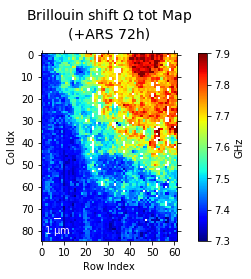

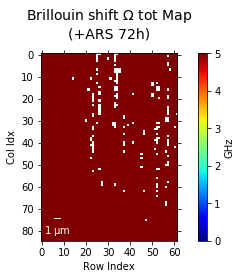

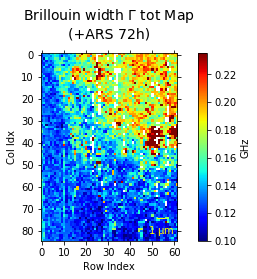

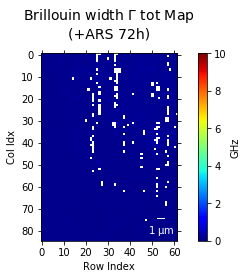

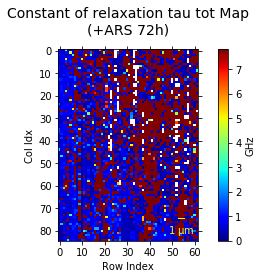

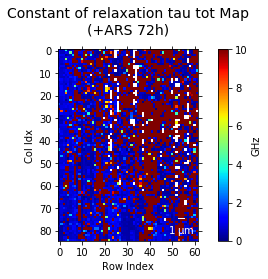

In [22]:
#STAMPA MAPPE tot
tau_min = 0
tau_max = 7.8
Print_Parameter_Map(omega_tot_map, omega_min, omega_max, 'Omega', 'tot', name = name, pix_scale = pix_scale, filename = 'omega_tot_map', path=now_path, bar_loc = 'lower left')
Print_Parameter_Map(Delta_omega_tot_map, 0, 5, 'Omega', 'tot', name = name, pix_scale = pix_scale, filename = 'Delta_omega_tot_map', path=now_path, bar_loc = 'lower left')
Print_Parameter_Map(gamma_tot_map, gamma_min, gamma_max, 'Gamma', 'tot', name = name, pix_scale = pix_scale, filename = 'gamma_tot_map', path=now_path, bar_color = 'yellow')
Print_Parameter_Map(Delta_gamma_tot_map, 0, 10, 'Gamma', 'tot', name = name, pix_scale = pix_scale, filename = 'DElta_gamma_tot_map', path=now_path)
Print_Parameter_Map(tau_map, tau_min, tau_max, 'Tau', 'tot', name = name, pix_scale = pix_scale, filename = 'tau_tot_map', path=now_path, bar_color = 'yellow')
Print_Parameter_Map(Delta_tau_map, 0, 10, 'Tau', 'tot', name = name, pix_scale = pix_scale, filename = 'DElta_tau_tot_map', path=now_path)

In [23]:
#INTERPOLATION MAPPE
omega_tot_map_inter = Interpolate_Parameter_Map(omega_tot_map, 'Omega', 'tot', matrix, n_rows, n_cols, tot_omega_min, tot_omega_max)
gamma_tot_map_inter = Interpolate_Parameter_Map(gamma_tot_map, 'Gamma', 'tot', matrix, n_rows, n_cols, tot_gamma_min, tot_gamma_max)
tau_tot_map_inter = Interpolate_Parameter_Map(tau_map, 'tau', 'tot', matrix, n_rows, n_cols, tot_tau_min, tot_gamma_max)

Completata Interpolazione per elementi di tot Omega map 

Completata Interpolazione per elementi di tot Gamma map 

Completata Interpolazione per elementi di tot tau map 



In [24]:
delta_tot_map, _ = Get_Parameter_Map('tot', 'Delta', matrix, n_rows, n_cols,excluded)
delta_tot_map

Completata Parameter_Map per Delta
Ho trovato 164 elementi saturati


array([[2.92714477e-01, 1.91636267e-01, 2.29895003e-01, ...,
        1.19131388e-01, 1.86564548e+01, 5.31509281e+00],
       [2.57493227e-01, 1.60295217e-01, 1.63330071e-01, ...,
        1.23195127e-01, 2.85383033e+02, 7.95422109e+00],
       [3.07618469e-01, 2.71433642e-01, 2.72853726e-01, ...,
        1.57501845e-01, 1.36144336e-01, 1.52404637e+01],
       ...,
       [1.14194344e-01, 1.14691519e-01, 1.66445405e-02, ...,
        1.71404061e+01, 3.33135625e+02, 2.96290860e-01],
       [1.05141613e-01, 1.58572610e-01, 2.71095324e-01, ...,
        1.18607785e-01, 4.43004282e+00, 7.91148707e+01],
       [1.10505883e-01, 1.14005879e-01, 1.79595708e-01, ...,
        1.74823109e-01, 1.73415268e-01, 2.76122090e-01]])

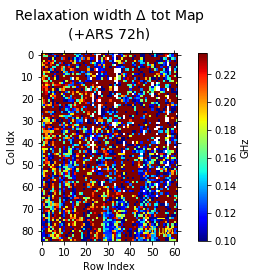

In [25]:
Print_Parameter_Map(delta_tot_map, gamma_min, gamma_max, 'Delta', 'tot', name = name, pix_scale = pix_scale, filename = 'delta_tot_map', path=now_path, bar_color = 'yellow')

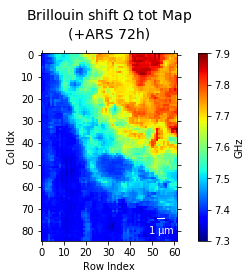

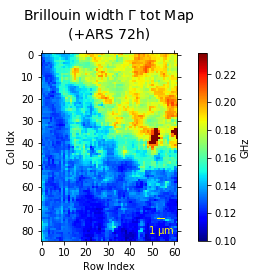

In [26]:
#STAMPA MAPPE INTERPOLATE
Print_Parameter_Map(omega_tot_map_inter, omega_min, omega_max, 'Omega', 'tot', name = name, pix_scale = pix_scale, filename = 'omega_tot_map_inter', path=now_path)
Print_Parameter_Map(gamma_tot_map_inter, gamma_min, gamma_max, 'Gamma', 'tot', name = name, pix_scale = pix_scale, filename = 'Gamma_tot_map_inter', path=now_path, bar_color = 'yellow')
#Print_Parameter_Map(tau_tot_map_inter, tau_min, tau_max, 'Gamma', 'tot', name = name, pix_scale = pix_scale, filename = 'Tau_tot_map_inter', path=now_path, bar_color = 'yellow')

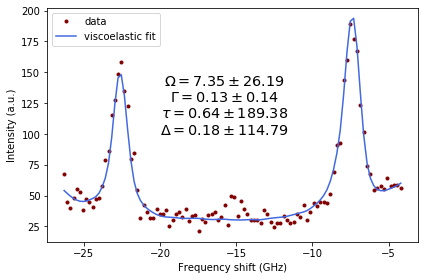

In [54]:
i = 5
j = 0
Data = matrix[i][j]
# TOT FIT EXAMPLE
f, ax = plt.subplots()
ax.plot(Data.x_freq, Data.y, '.', color = 'maroon', label = 'data')
ax.plot(Data.x_freq, Data.y_fit, color = 'royalblue', label = 'viscoelastic fit')
ax.set_xlabel('Frequency shift (GHz)')
ax.set_ylabel('Intensity (a.u.)')
ax.text(-20, 100, '$\Omega = {:3.2f} \pm {:3.2f}$\n$\Gamma = {:3.2f} \pm {:3.2f}$\n'.format(Data.Tot_Fit_Params.T['Values']['Omega'], Data.Tot_Fit_Params.T['StdErrs']['Omega'], Data.Tot_Fit_Params.T['Values']['Gamma'], Data.Tot_Fit_Params.T['StdErrs']['Gamma'])+ r'$\tau = {:3.2f} \pm {:3.2f}$'.format( Data.Tot_Fit_Params.T['Values']['tau'], Data.Tot_Fit_Params.T['StdErrs']['tau'])+ '\n'+ r'$\Delta = {:3.2f} \pm {:3.2f}$'.format( Data.Tot_Fit_Params.T['Values']['Delta'], Data.Tot_Fit_Params.T['StdErrs']['Delta']), ma = 'center', size = 'x-large', in_layout = True, fontstyle = 'italic', fontfamily = 'monospace')
ax.legend()
plt.tight_layout()
f.savefig('../Scrittek/figures/Tot_fit_example_acqua.pdf', format = 'pdf')

In [31]:
omegas = []
gammas = []

for ii,jj in boni:
    omegas.append(matrix[ii][jj].Tot_Fit_Params['Omega'].values[0])
    gammas.append(matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0])
#omegas.sort()
#gammas.sort()

In [36]:
for ii in range(len(omegas)):
    if (omegas[ii] <= 7.38) & (omegas[ii] >= 7.35):
        print ('{} \t {:3.2f} \t {:3.2f}'.format(ii, omegas[ii], gammas[ii]))

57 	 7.36 	 0.13
173 	 7.37 	 0.15
175 	 7.38 	 0.13
176 	 7.36 	 0.12
296 	 7.36 	 0.12
297 	 7.35 	 0.13
302 	 7.37 	 0.14
517 	 7.36 	 0.23
533 	 7.37 	 0.13
534 	 7.37 	 0.12
655 	 7.36 	 0.13
657 	 7.36 	 0.12
773 	 7.35 	 0.14
774 	 7.37 	 0.13
776 	 7.37 	 0.11
892 	 7.36 	 0.14
893 	 7.36 	 0.13
895 	 7.37 	 0.14
1005 	 7.37 	 0.13
1007 	 7.38 	 0.13
1123 	 7.37 	 0.13
1126 	 7.36 	 0.12
1236 	 7.37 	 0.13
1240 	 7.37 	 0.14
1248 	 7.38 	 0.15
1249 	 7.38 	 0.16
1355 	 7.37 	 0.13
1357 	 7.37 	 0.13
1364 	 7.37 	 0.12
1473 	 7.37 	 0.13
1475 	 7.38 	 0.13
1480 	 7.38 	 0.13
1483 	 7.37 	 0.15
1599 	 7.37 	 0.14
1706 	 7.37 	 0.12
1707 	 7.37 	 0.13
1713 	 7.37 	 0.13
1716 	 7.38 	 0.14
1722 	 7.37 	 0.12
1826 	 7.37 	 0.14
1830 	 7.37 	 0.13
1833 	 7.38 	 0.15
1937 	 7.36 	 0.14
1946 	 7.37 	 0.15
1958 	 7.36 	 0.12
2052 	 7.37 	 0.15
2054 	 7.37 	 0.13
2055 	 7.35 	 0.13
2056 	 7.36 	 0.15
2066 	 7.38 	 0.13
2069 	 7.37 	 0.13
2169 	 7.36 	 0.21
2172 	 7.35 	 0.14
2174 	 7.38 

In [51]:
count = 0
for (ii,jj) in boni:
    if (count == 297):
        print(str((ii,jj)))
        
    count+=1

(5, 0)


(5, 0)
                Co      Omega     Gamma       Delta         tau  \
Values    0.008091   7.351456  0.127011    0.184667    0.636334   
StdErrs   0.030154  26.190218  0.140415  114.789339  189.382043   
Initials  0.007940   7.425713  0.128293    0.128293    1.000000   

          delta_position  delta_width  delta_amplitude     shift     offset  
Values          0.784895     0.280987         0.045821 -0.027660  19.820710  
StdErrs         0.662810     0.401463         0.055829  0.023482   4.491296  
Initials        0.771787     0.283825         0.046284 -0.027324  19.855345  


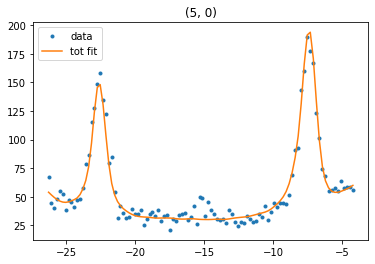

In [52]:
Plot_Elements_Spectrum(matrix, [(5,0)], fit = 'tot')